In [1]:
# !pip install gymnasium
# !pip install gymnasium[classic_control]

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import skfuzzy as fuzz
from skfuzzy import control as ctrl
RAND_SEED = 2023

Defining fuzzy controller input and output along with their boundaries

In [3]:
#x1 = ctrl.Antecedent(np.linspace(-1.2, 0.6, 1000), 'position') # 1000 points between 0 to 1 inclusive
x2 = ctrl.Antecedent(np.linspace(-0.07, 0.07, 1000), 'velocity') # 1000 points between 0 to 1 inclusive
y = ctrl.Consequent(np.linspace(-1, 1, 1000), 'action') # 1000 points between 0.004 to 0.01 inclusive

Position language terms and fuzzifiers

In [4]:
# x1['left'] = fuzz.trapmf(x1.universe, [-1.2, -1.2, -0.5, -0.1]) # trapezoidal membership
# x1['right'] = fuzz.trapmf(x1.universe, [-0.5, -0.1, 0.6, 0.6]) # trapezoidal membership

# x1.view()

Velocity language terms and fuzzifiers

c:\Users\erfan\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


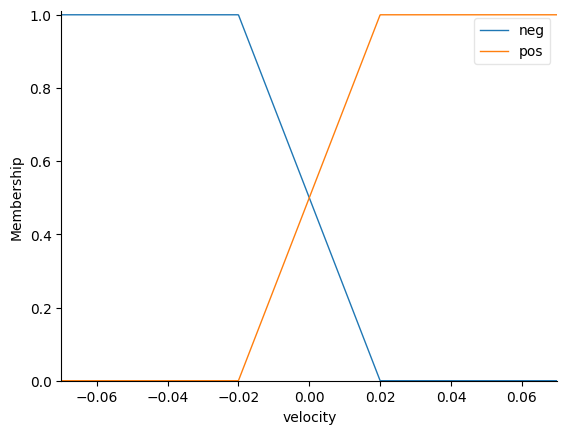

In [5]:
x2['neg'] = fuzz.trapmf(x2.universe, [-0.07, -0.07, -0.02, 0.02]) # trapezoidal membership
x2['pos'] = fuzz.trapmf(x2.universe, [-0.02, 0.02, 0.07, 0.07]) # trapezoidal membership

x2.view()

Acceleration (action) language terms and defuzzifiers

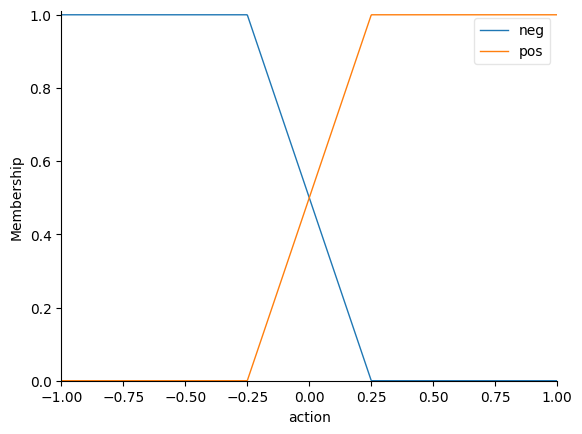

In [6]:
y['neg'] = fuzz.trapmf(y.universe, [-1, -1, -0.25, 0.25]) # trapezoidal membership
y['pos'] = fuzz.trapmf(y.universe, [-0.25, 0.25, 1, 1]) # trapezoidal membership

y.view()

Creating a rule base for the following simple strategy:<br>
If you are on the left side of the curve and going left, keep accelerating left otherwise accelerate in right direction.<br>
If you are on the right side of the curve and going right, keep accelerating right, otherwise accelerate in left direction.

In [7]:
# list_rules = []
# list_rules.append(ctrl.Rule(x1['left'] & x2['neg'], y['neg']))
# list_rules.append(ctrl.Rule(x1['left'] & x2['pos'], y['pos']))
# list_rules.append(ctrl.Rule(x1['right'] & x2['neg'], y['neg']))
# list_rules.append(ctrl.Rule(x1['right']& x2['pos'], y['pos']))

list_rules = []
list_rules.append(ctrl.Rule(x2['neg'], y['neg']))
list_rules.append(ctrl.Rule(x2['pos'], y['pos']))
list_rules.append(ctrl.Rule(x2['neg'], y['neg']))
list_rules.append(ctrl.Rule(x2['pos'], y['pos']))

Creating the fuzzy control system and a simulator to compute best course of action providing current inputs

In [8]:
car_ctrl = ctrl.ControlSystem(list_rules)
car = ctrl.ControlSystemSimulation(car_ctrl)

Testing fuzzy controller for given dummy inputs

0.48958286333098594


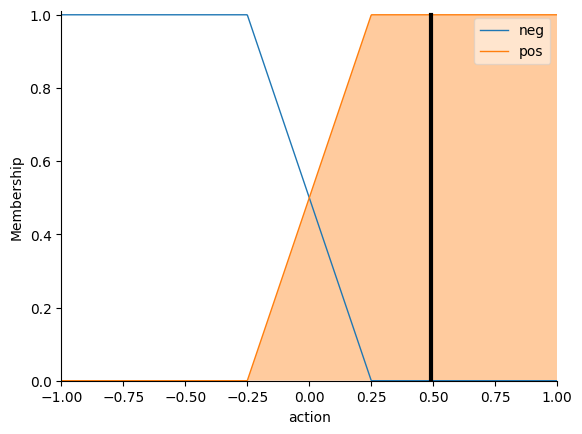

In [9]:
#car.input['position'] = 0.65
car.input['velocity'] = 0.5
car.compute()
a = car.output["action"]
print(a)
y.view(sim=car)

Creating the simulator<br>
Simulator consists of a main loop in which it observes the env and provide the controller with observed inputs.<br>
Then the controller computes the suitable acceleration considering current observed inputs 

In [10]:
def run_simulation(max_steps = 500):
    ls_frames = []
    ls_obs = []
    ls_actions = []
    ls_rewards = []
    
    env = gym.make("MountainCarContinuous-v0", render_mode = 'rgb_array')
    
    obs = env.reset(seed=RAND_SEED)[0]
    ls_obs.append(obs)
    
    ls_frames.append(env.render())

    for i in range(max_steps):
        #car.input['position'] = obs[0]
        car.input['velocity'] = obs[1]
        car.compute()
        a = car.output["action"]
        
        
        action = np.array([a])
        ls_actions.append(action)

        obs, reward, terminated, _, _ = env.step(action)
        ls_obs.append(obs)
        ls_rewards.append(reward)

        ls_frames.append(env.render())
        
        if terminated:
            break

    env.close()
    return ls_frames, ls_obs, ls_actions, ls_rewards, i

<img src="Car_Fuzzy_Controller_Simulation_RS2023.gif" height=320 width=400><br>
You should see the same simulation as in the picture in a file named "Car_Fuzzy_Controller_Simulation_RS{RAND_SEED}.gif"

In [11]:
ls_frames, ls_obs, ls_actions, ls_rewards, steps= run_simulation()
print(f'Simulation Compeleted: Took {steps} steps')
print(f'Car Started from Position = {ls_obs[0][0]}')
print(f'Car Goal Position >= 0.45')
print(f'Car Reached Position = {ls_obs[-1][0]}')

c:\Users\erfan\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Simulation Compeleted: Took 194 steps
Car Started from Position = -0.5823891162872314
Car Goal Position >= 0.45
Car Reached Position = 0.4623347818851471


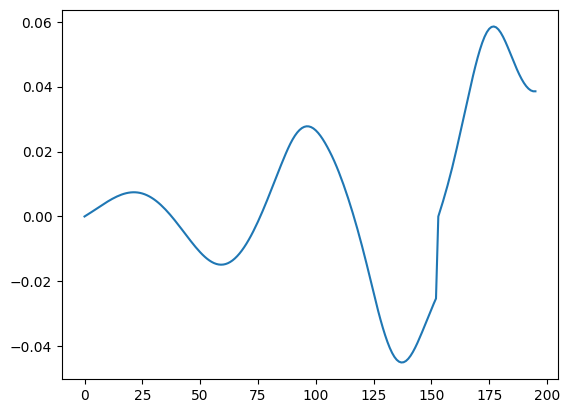

In [12]:
plt.plot([x[1] for x in ls_obs])

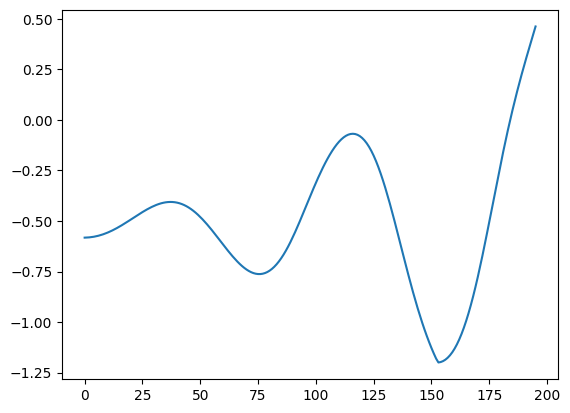

In [13]:
plt.plot([x[0] for x in ls_obs])

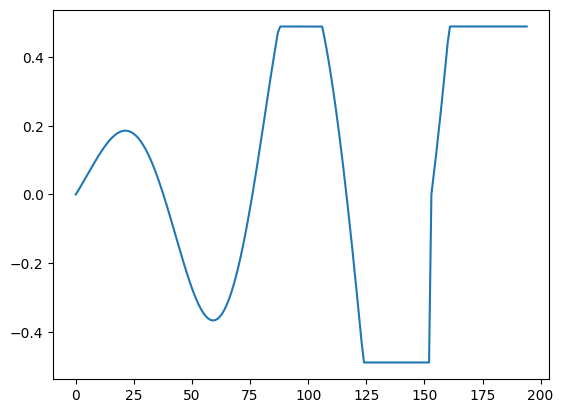

In [14]:
plt.plot(ls_actions)

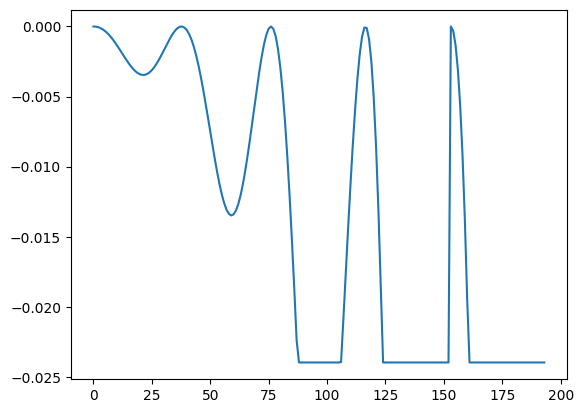

In [15]:
plt.plot(ls_rewards[:-1])

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, filename, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save(filename)
    plt.close()
    return anim

In [17]:
plot_animation(ls_frames, f'Car_Fuzzy_Controller_Simulation_RS{str(RAND_SEED)}.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.
